In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [752]:
# Combine CSV files
file_path_1 = '../data/2024-08-25-granular-mac.csv'
file_path_2 = '../data/2024-08-25-granular-windows.csv'
output_file_path = '../data/2024-08-25-granular-combined.csv'

df_mac = pd.read_csv(file_path_1)
df_windows = pd.read_csv(file_path_2)

df_combined = df_mac._append(df_windows, ignore_index=True)

df_combined.to_csv(output_file_path, index=False)

In [977]:
# Read CSV file
data = pd.read_csv('../data/2024-08-26-test-mac.csv')
print(f'{len(data)} rows')

5440 rows


## Histograms

In [655]:
filtered_data = data[
    (data["Blood pressure hypotension"] == 'normal') &
    (data['CVP pressure'] == 'normal') &
    (data['Injection location'].isna()) &
    (data['Occluded'].isna()) &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

3417 rows


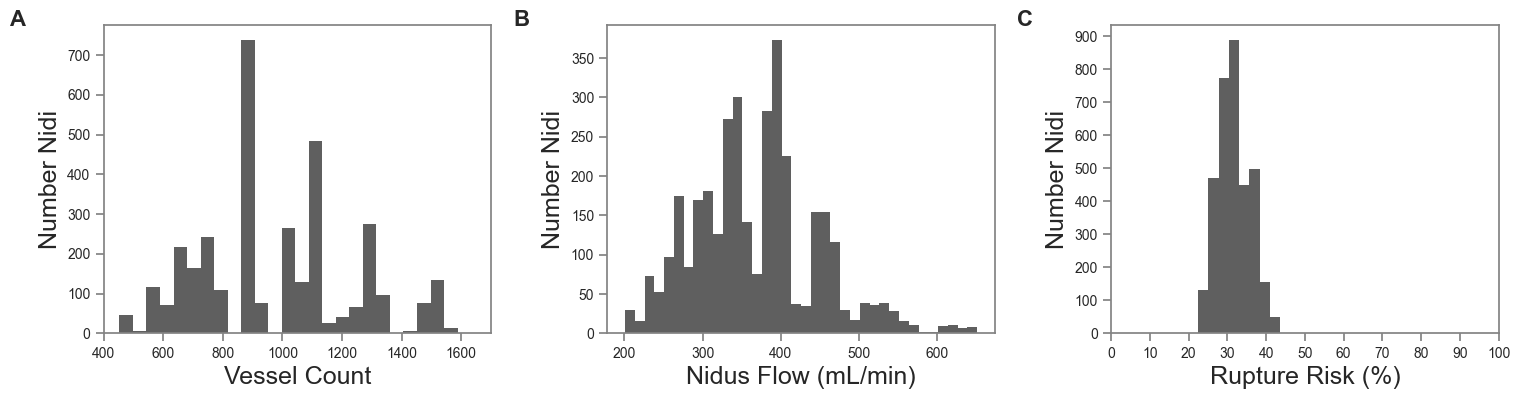

Average total flow is 367.9426710433989 mL/min


In [658]:
sns.set_theme(style='whitegrid', font_scale=1.5)

fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
plt.subplots_adjust(wspace=0.3)

sns.histplot(
    filtered_data['Num vessels'], 
    ax=axs[0],
)

sns.histplot(
    filtered_data['Feeder total flow (mL/min)'], 
    ax=axs[1],
)

sns.histplot(
    filtered_data['Mean rupture risk (%)'], 
    ax=axs[2],
    binwidth=2.5
)

####################
# COMMON FORMATTING
####################

for i, ax in enumerate(axs):

    ax.grid(False)

    plt.setp(
        ax.patches,
        facecolor='#5f5f5f',
        linewidth=0,
    )

    plt.setp(
        ax.spines.values(),
        edgecolor='#838383',
    )

    plt.setp(
        ax,
        ylabel='Number Nidi',
    )

    ax.tick_params(
        axis='x',
        labelsize=10,
        bottom=True,
        color=ax.spines['bottom'].get_edgecolor(),
        which='both',
    )

    ax.tick_params(
        axis='y',
        labelsize=10,
        left=True,
        color=ax.spines['left'].get_edgecolor(),
        which='both',
    )

    ax.text(-0.2, 1.05, 'ABC'[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

#######
# AX 0
#######

plt.setp(
    axs[0],
    xlabel='Vessel Count',
    xlim=[400, 1700],
    xticks=range(400, 1700, 200),
    # yticks=range(0, 1201, 200),
)

#######
# AX 1
#######

plt.setp(
    axs[1],
    xlabel='Nidus Flow (mL/min)',
    # yticks=range(0, 701, 100),
)

#######
# AX 2
#######

plt.setp(
    axs[2],
    xlabel='Rupture Risk (%)',
    xlim=[0, 100],
    xticks=range(0, 101, 10),
    yticks=range(0, 901, 100)
)

print(f'Average total flow is {np.mean(filtered_data['Feeder total flow (mL/min)'])} mL/min')


## Flow by Injection Pressure

In [675]:
filtered_data = data[
    (data['Occluded'].isna()) &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

182240 rows


In [676]:
grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure']).agg({
    'Feeder total flow (mL/min)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure', 'flow_mean', 'flow_std']

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

grouped_data['CVP pressure'] = pd.Categorical(
    grouped_data['CVP pressure'],
    categories=['normal', 'elevated'],
    ordered=True,
)

grouped_data = grouped_data.sort_values(by=['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure']).reset_index(drop=True)

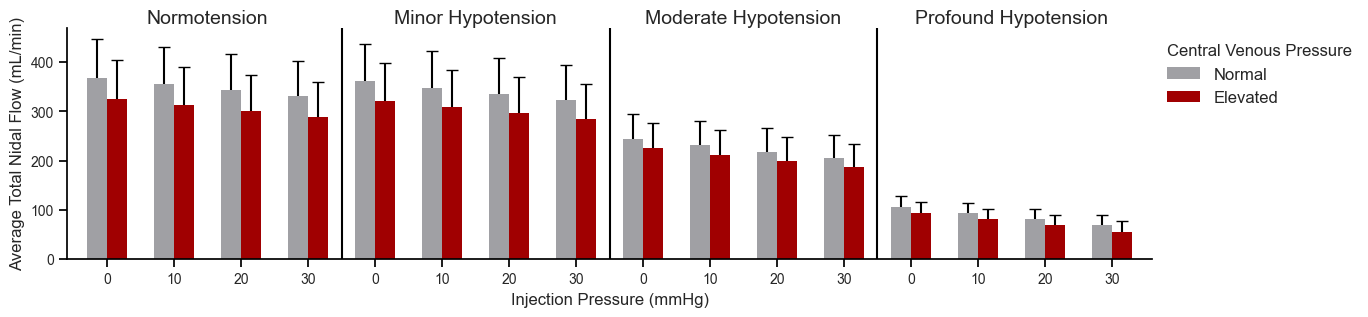

In [677]:
BORDER_COLOR = 'black'

x = np.arange(len(grouped_data) // 2)  # Positions for each pair
width = 0.3  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 3))

ax.bar(x - width/2, grouped_data[grouped_data['CVP pressure'] == 'normal']['flow_mean'].values, width, color='#a0a0a4', label='Normal', edgecolor='none')
ax.bar(x + width/2, grouped_data[grouped_data['CVP pressure'] == 'elevated']['flow_mean'].values, width, color='#a00001', label='Elevated', edgecolor='none')

ax.errorbar(
    x - width/2,
    grouped_data[grouped_data['CVP pressure'] == 'normal']['flow_mean'].values, 
    yerr=grouped_data[grouped_data['CVP pressure'] == 'normal']['flow_std'].values, 
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=-1,
)

ax.errorbar(
    x + width/2,
    grouped_data[grouped_data['CVP pressure'] == 'elevated']['flow_mean'].values, 
    yerr=grouped_data[grouped_data['CVP pressure'] == 'normal']['flow_std'].values, 
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=-1,
)

plt.setp(
    ax,
    xlim=[-width*2, x[-1] + width*2],
    xticks=x,
    xticklabels=['0', '10', '20', '30'] * 4,
    xlabel='Injection Pressure (mmHg)',
    ylabel='Average Total Nidal Flow (mL/min)',
)

plt.setp(
    ax.spines.values(),
    edgecolor=BORDER_COLOR,
)

plt.setp([ax.xaxis.label, ax.yaxis.label], fontsize=12)

ax.tick_params(
    axis='x',
    labelsize=10,
    bottom=True,
    color=ax.spines['bottom'].get_edgecolor(),
    which='both',
)

ax.tick_params(
    axis='y',
    labelsize=10,
    left=True,
    color=ax.spines['left'].get_edgecolor(),
    which='both',
)

plt.setp([ax.spines['top'], ax.spines['right']], visible=False)

categories = ['Normotension', 'Minor Hypotension', 'Moderate Hypotension', 'Profound Hypotension']
category_positions = [np.mean(x[i*4:(i+1)*4]) for i in range(4)]

for i, label in enumerate(categories):
    ax.text(category_positions[i], ax.get_ylim()[1] + 10, label, ha='center', fontsize=14)

for i in range(1, 4):
    ax.axvline(np.mean(x[i*4-1:i*4+1]), color=BORDER_COLOR, linewidth=1.5)

ax.legend(
    title="Central Venous Pressure",
    loc='center left',
    bbox_to_anchor=(1, 0.8),
    frameon=False,
    alignment='left',
    fontsize=12,
    title_fontsize=12,
)

plt.grid(False)

In [679]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') & 
    (grouped_data['CVP pressure'] == 'normal') & 
    (grouped_data['Injection pressure (mmHg)'] == 0) &
    (1 == 1)  # Ignore
]['flow_mean'].values[0]

print(value)


106.00902923658803


## Filling by Injection Pressure

In [680]:
filtered_data = data[
    (~data['Injection location'].isna()) &
    (data['Occluded'].isna()) &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

164016 rows


In [681]:
grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure']).agg({
    'Percent filled post-injection (%)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure', 'filling_mean', 'filling_std']

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

grouped_data['CVP pressure'] = pd.Categorical(
    grouped_data['CVP pressure'],
    categories=['normal', 'elevated'],
    ordered=True,
)

grouped_data = grouped_data.sort_values(by=['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure']).reset_index(drop=True)

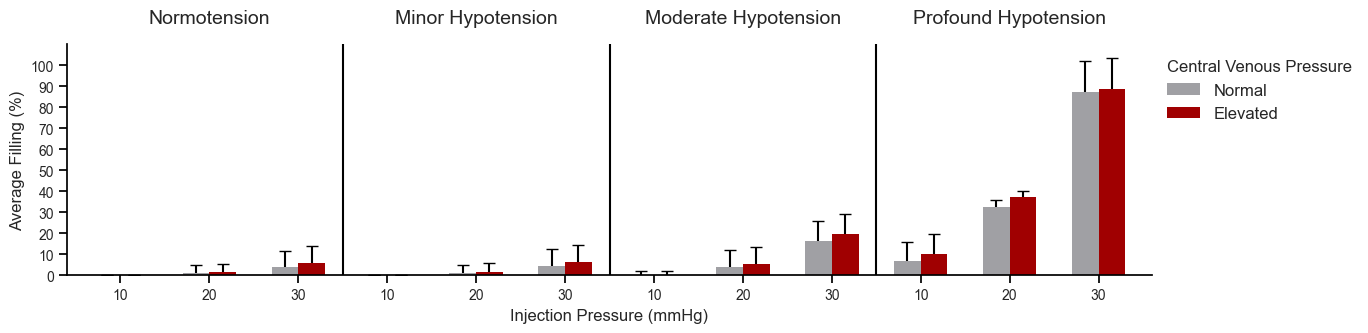

In [682]:
BORDER_COLOR = 'black'

x = np.arange(len(grouped_data) // 2)  # Positions for each pair
width = 0.3  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 3))

ax.bar(x - width/2, grouped_data[grouped_data['CVP pressure'] == 'normal']['filling_mean'].values, width, color='#a0a0a4', label='Normal', edgecolor='none')
ax.bar(x + width/2, grouped_data[grouped_data['CVP pressure'] == 'elevated']['filling_mean'].values, width, color='#a00001', label='Elevated', edgecolor='none')

ax.errorbar(
    x - width/2,
    grouped_data[grouped_data['CVP pressure'] == 'normal']['filling_mean'].values, 
    yerr=grouped_data[grouped_data['CVP pressure'] == 'normal']['filling_std'].values, 
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=-1,
)

ax.errorbar(
    x + width/2,
    grouped_data[grouped_data['CVP pressure'] == 'elevated']['filling_mean'].values, 
    yerr=grouped_data[grouped_data['CVP pressure'] == 'normal']['filling_std'].values, 
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=-1,
)

plt.setp(
    ax,
    xlim=[-width*2, x[-1] + width*2],
    xticks=x,
    xticklabels=['10', '20', '30'] * 4,
    xlabel='Injection Pressure (mmHg)',
    ylabel='Average Filling (%)',
    ylim=[0, 110],
    yticks=range(0, 101, 10),
)

plt.setp(
    ax.spines.values(),
    edgecolor=BORDER_COLOR,
)

plt.setp([ax.xaxis.label, ax.yaxis.label], fontsize=12)

ax.tick_params(
    axis='x',
    labelsize=10,
    bottom=True,
    color=ax.spines['bottom'].get_edgecolor(),
    which='both',
)

ax.tick_params(
    axis='y',
    labelsize=10,
    left=True,
    color=ax.spines['left'].get_edgecolor(),
    which='both',
)

plt.setp([ax.spines['top'], ax.spines['right']], visible=False)

categories = ['Normotension', 'Minor Hypotension', 'Moderate Hypotension', 'Profound Hypotension']
category_positions = [np.mean(x[i*3:(i+1)*3]) for i in range(4)]

for i, label in enumerate(categories):
    ax.text(category_positions[i], ax.get_ylim()[1] + 10, label, ha='center', fontsize=14)

for i in range(1, 4):
    ax.axvline(np.mean(x[i*3-1:i*3+1]), color=BORDER_COLOR, linewidth=1.5)

ax.legend(
    title="Central Venous Pressure",
    loc='center left',
    bbox_to_anchor=(1, 0.8),
    frameon=False,
    alignment='left',
    fontsize=12,
    title_fontsize=12,
)

plt.grid(False)


In [690]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') & 
    (grouped_data['CVP pressure'] == 'normal') & 
    (grouped_data['Injection pressure (mmHg)'] == 20) &
    (1 == 1)  # Ignore
]['filling_mean'].values[0]

print(value)

32.58383974246415


## Filling by Injection Location

In [691]:
filtered_data = data[
    (~data['Injection location'].isna()) &
    (data['Occluded'].isna()) &
    (data['Injection pressure (mmHg)'] == 30) &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

54672 rows


In [692]:
grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Injection location', 'CVP pressure']).agg({
    'Percent filled post-injection (%)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Injection location', 'CVP pressure', 'filling_mean', 'filling_std']

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

grouped_data['CVP pressure'] = pd.Categorical(
    grouped_data['CVP pressure'],
    categories=['normal', 'elevated'],
    ordered=True,
)

grouped_data['Injection location'] = pd.Categorical(
    grouped_data['Injection location'],
    categories=['DV1', 'DV2', 'DV3'],
    ordered=True,
)

grouped_data = grouped_data.sort_values(by=['Blood pressure hypotension', 'Injection location', 'CVP pressure']).reset_index(drop=True)

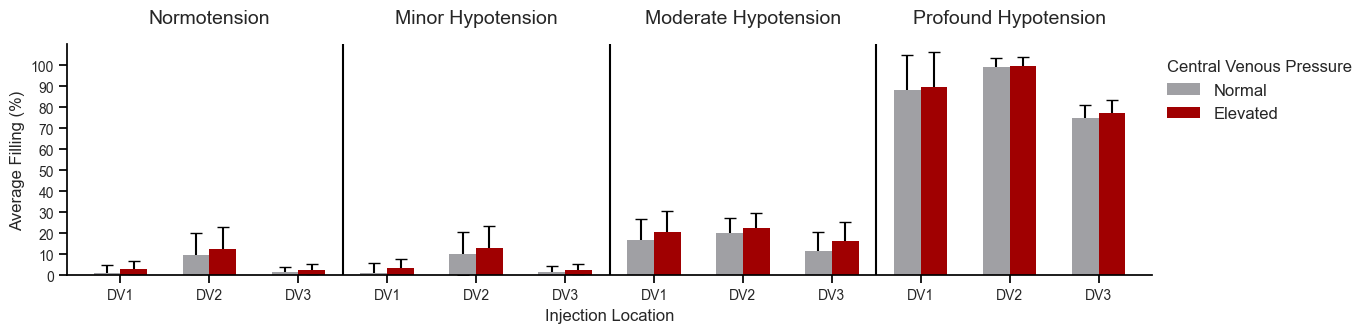

In [693]:
BORDER_COLOR = 'black'

x = np.arange(len(grouped_data) // 2)  # Positions for each pair
width = 0.3  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 3))

ax.bar(x - width/2, grouped_data[grouped_data['CVP pressure'] == 'normal']['filling_mean'].values, width, color='#a0a0a4', label='Normal', edgecolor='none')
ax.bar(x + width/2, grouped_data[grouped_data['CVP pressure'] == 'elevated']['filling_mean'].values, width, color='#a00001', label='Elevated', edgecolor='none')

ax.errorbar(
    x - width/2,
    grouped_data[grouped_data['CVP pressure'] == 'normal']['filling_mean'].values, 
    yerr=grouped_data[grouped_data['CVP pressure'] == 'normal']['filling_std'].values, 
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=-1,
)

ax.errorbar(
    x + width/2,
    grouped_data[grouped_data['CVP pressure'] == 'elevated']['filling_mean'].values, 
    yerr=grouped_data[grouped_data['CVP pressure'] == 'normal']['filling_std'].values, 
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=-1,
)

plt.setp(
    ax,
    xlim=[-width*2, x[-1] + width*2],
    xticks=x,
    xticklabels=['DV1', 'DV2', 'DV3'] * 4,
    xlabel='Injection Location',
    ylabel='Average Filling (%)',
    ylim=[0, 110],
    yticks=range(0, 101, 10),
)

plt.setp(
    ax.spines.values(),
    edgecolor=BORDER_COLOR,
)

plt.setp([ax.xaxis.label, ax.yaxis.label], fontsize=12)

ax.tick_params(
    axis='x',
    labelsize=10,
    bottom=True,
    color=ax.spines['bottom'].get_edgecolor(),
    which='both',
)

ax.tick_params(
    axis='y',
    labelsize=10,
    left=True,
    color=ax.spines['left'].get_edgecolor(),
    which='both',
)

plt.setp([ax.spines['top'], ax.spines['right']], visible=False)

categories = ['Normotension', 'Minor Hypotension', 'Moderate Hypotension', 'Profound Hypotension']
category_positions = [np.mean(x[i*3:(i+1)*3]) for i in range(4)]

for i, label in enumerate(categories):
    ax.text(category_positions[i], ax.get_ylim()[1] + 10, label, ha='center', fontsize=14)

for i in range(1, 4):
    ax.axvline(np.mean(x[i*3-1:i*3+1]), color=BORDER_COLOR, linewidth=1.5)

ax.legend(
    title="Central Venous Pressure",
    loc='center left',
    bbox_to_anchor=(1, 0.8),
    frameon=False,
    alignment='left',
    fontsize=12,
    title_fontsize=12,
)

plt.grid(False)

In [697]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') &
    (grouped_data['CVP pressure'] == 'normal') &
    (grouped_data['Injection location'] == 'DV3') &
    (1 == 1)  # Ignore
]['filling_mean'].values[0]

print(value)

74.71415071700322


## Rupture Risk

In [698]:
filtered_data = data[
    (data['Occluded'].isna()) &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

182240 rows


In [699]:
grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure']).agg({
    'Mean rupture risk (%)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure', 'risk_mean', 'risk_std']

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

grouped_data['CVP pressure'] = pd.Categorical(
    grouped_data['CVP pressure'],
    categories=['normal', 'elevated'],
    ordered=True,
)

grouped_data = grouped_data.sort_values(by=['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure']).reset_index(drop=True)

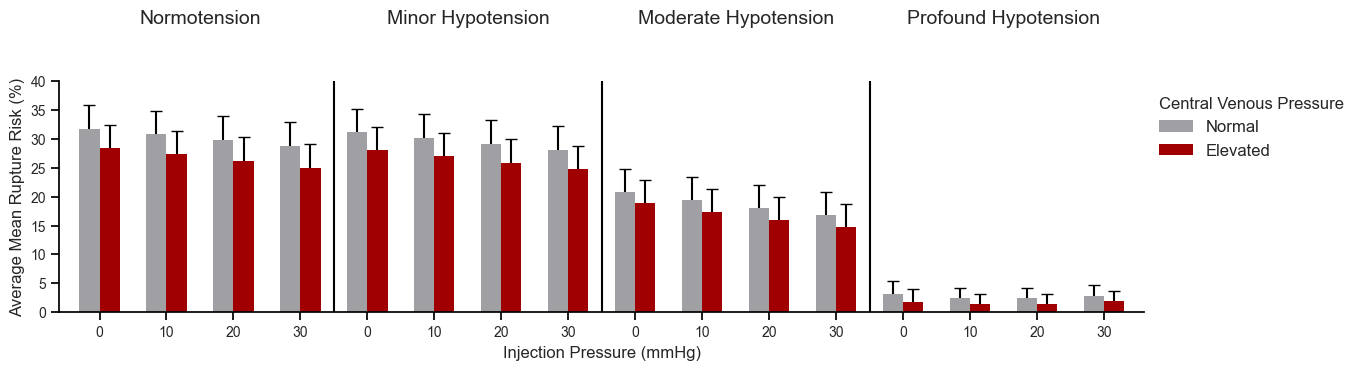

In [703]:
BORDER_COLOR = 'black'

x = np.arange(len(grouped_data) // 2)  # Positions for each pair
width = 0.3  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 3))

ax.bar(x - width/2, grouped_data[grouped_data['CVP pressure'] == 'normal']['risk_mean'].values, width, color='#a0a0a4', label='Normal', edgecolor='none')
ax.bar(x + width/2, grouped_data[grouped_data['CVP pressure'] == 'elevated']['risk_mean'].values, width, color='#a00001', label='Elevated', edgecolor='none')

ax.errorbar(
    x - width/2,
    grouped_data[grouped_data['CVP pressure'] == 'normal']['risk_mean'].values, 
    yerr=grouped_data[grouped_data['CVP pressure'] == 'normal']['risk_std'].values, 
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=-1,
)

ax.errorbar(
    x + width/2,
    grouped_data[grouped_data['CVP pressure'] == 'elevated']['risk_mean'].values, 
    yerr=grouped_data[grouped_data['CVP pressure'] == 'normal']['risk_std'].values, 
    fmt='none',
    ecolor='black',
    capsize=4,
    zorder=-1,
)

plt.setp(
    ax,
    xlim=[-width*2, x[-1] + width*2],
    xticks=x,
    xticklabels=['0', '10', '20', '30'] * 4,
    xlabel='Injection Pressure (mmHg)',
    ylabel='Average Mean Rupture Risk (%)',
    ylim=[0, 40],
)

plt.setp(
    ax.spines.values(),
    edgecolor=BORDER_COLOR,
)

plt.setp([ax.xaxis.label, ax.yaxis.label], fontsize=12)

ax.tick_params(
    axis='x',
    labelsize=10,
    bottom=True,
    color=ax.spines['bottom'].get_edgecolor(),
    which='both',
)

ax.tick_params(
    axis='y',
    labelsize=10,
    left=True,
    color=ax.spines['left'].get_edgecolor(),
    which='both',
)

plt.setp([ax.spines['top'], ax.spines['right']], visible=False)

categories = ['Normotension', 'Minor Hypotension', 'Moderate Hypotension', 'Profound Hypotension']
category_positions = [np.mean(x[i*4:(i+1)*4]) for i in range(4)]

for i, label in enumerate(categories):
    ax.text(category_positions[i], ax.get_ylim()[1] + 10, label, ha='center', fontsize=14)

for i in range(1, 4):
    ax.axvline(np.mean(x[i*4-1:i*4+1]), color=BORDER_COLOR, linewidth=1.5)

ax.legend(
    title="Central Venous Pressure",
    loc='center left',
    bbox_to_anchor=(1, 0.8),
    frameon=False,
    alignment='left',
    fontsize=12,
    title_fontsize=12,
)

plt.grid(False)

In [705]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') &
    (grouped_data['Injection pressure (mmHg)'] == 30) &
    (grouped_data['CVP pressure'] == 'elevated') &
    (1 == 1)  # Ignore
]['risk_mean'].values[0]

print(value)

1.9130878255779924


## Filling Summary

In [706]:
filtered_data = data[
    (~data['Injection location'].isna()) &
    (data['Occluded'].isna()) &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

164016 rows


In [707]:
grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure', 'Injection location']).agg({
    'Percent filled post-injection (%)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure', 'Injection location', 'filling_mean', 'filling_std']

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

grouped_data['CVP pressure'] = pd.Categorical(
    grouped_data['CVP pressure'],
    categories=['normal', 'elevated'],
    ordered=True,
)

grouped_data['Injection location'] = pd.Categorical(
    grouped_data['Injection location'],
    categories=['DV1', 'DV2', 'DV3'],
    ordered=True,
)

grouped_data = grouped_data.sort_values(by=['Blood pressure hypotension', 'Injection pressure (mmHg)', 'CVP pressure', 'Injection location']).reset_index(drop=True)

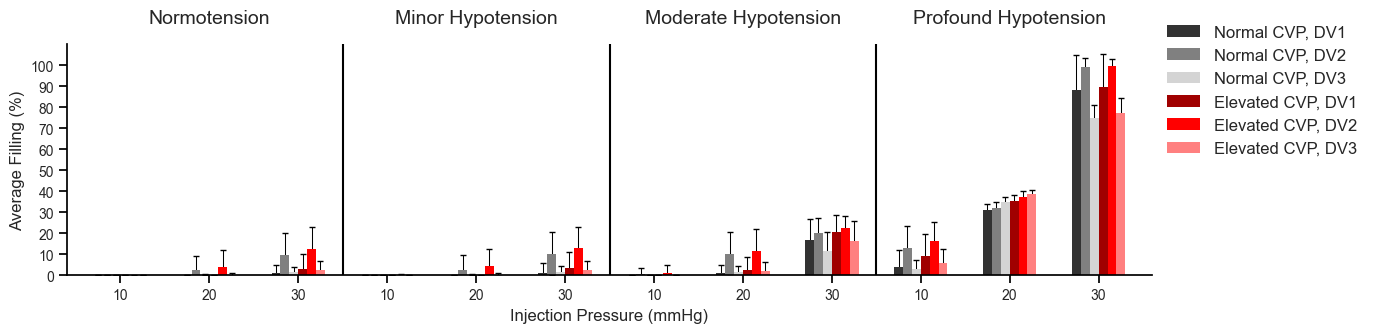

In [708]:
BORDER_COLOR = 'black'

x = np.arange(len(grouped_data) // 6)  # Positions for each injection pressure group
width = 0.1  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 3))

bar_data = [
    grouped_data[(grouped_data['CVP pressure'] == 'normal') & (grouped_data['Injection location'] == 'DV1')],
    grouped_data[(grouped_data['CVP pressure'] == 'normal') & (grouped_data['Injection location'] == 'DV2')],
    grouped_data[(grouped_data['CVP pressure'] == 'normal') & (grouped_data['Injection location'] == 'DV3')],
    grouped_data[(grouped_data['CVP pressure'] == 'elevated') & (grouped_data['Injection location'] == 'DV1')],
    grouped_data[(grouped_data['CVP pressure'] == 'elevated') & (grouped_data['Injection location'] == 'DV2')],
    grouped_data[(grouped_data['CVP pressure'] == 'elevated') & (grouped_data['Injection location'] == 'DV3')],
]

bar_colors = [
    '#323232',
    '#808080',
    '#d4d4d4',
    '#a00000',
    '#ff0000',
    '#ff8080',
]

bar_labels = [
    'Normal CVP, DV1',
    'Normal CVP, DV2',
    'Normal CVP, DV3',
    'Elevated CVP, DV1',
    'Elevated CVP, DV2',
    'Elevated CVP, DV3',
]

for i in range(len(bar_data)):
    ax.bar(x - width*2.5 + width*i, bar_data[i]['filling_mean'].values, width, color=bar_colors[i], label=bar_labels[i], edgecolor='none')
    ax.errorbar(x - width*2.5 + width*i, bar_data[i]['filling_mean'].values, yerr=bar_data[i]['filling_std'].values, fmt='none', ecolor='black', capsize=2, elinewidth=0.75, zorder=-1)

plt.setp(
    ax,
    xlim=[-width*6, x[-1] + width*6],
    xticks=x,
    xticklabels=['10', '20', '30'] * 4,
    xlabel='Injection Pressure (mmHg)',
    ylabel='Average Filling (%)',
    ylim=[0, 110],
    yticks=range(0, 101, 10),
)

plt.setp(
    ax.spines.values(),
    edgecolor=BORDER_COLOR,
)

plt.setp([ax.xaxis.label, ax.yaxis.label], fontsize=12)

ax.tick_params(
    axis='x',
    labelsize=10,
    bottom=True,
    color=ax.spines['bottom'].get_edgecolor(),
    which='both',
)

ax.tick_params(
    axis='y',
    labelsize=10,
    left=True,
    color=ax.spines['left'].get_edgecolor(),
    which='both',
)

plt.setp([ax.spines['top'], ax.spines['right']], visible=False)

categories = ['Normotension', 'Minor Hypotension', 'Moderate Hypotension', 'Profound Hypotension']
category_positions = [np.mean(x[i*3:(i+1)*3]) for i in range(4)]

for i, label in enumerate(categories):
    ax.text(category_positions[i], ax.get_ylim()[1] + 10, label, ha='center', fontsize=14)

for i in range(1, 4):
    ax.axvline(np.mean(x[i*3-1:i*3+1]), color=BORDER_COLOR, linewidth=1.5)

ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.8),
    frameon=False,
    alignment='left',
    fontsize=12,
)

plt.grid(False)


In [709]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') & 
    (grouped_data['CVP pressure'] == 'normal') & 
    (grouped_data['Injection pressure (mmHg)'] == 30) &
    (1 == 1)  # Ignore
]['filling_mean'].values[0]

print(value)

88.12677866549606


## Occlusion by Injection Pressure

In [858]:
filtered_data = data[
    (~data['Injection location'].isna()) &
    (data['CVP pressure'] == 'normal') &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

492048 rows


In [859]:
filtered_data.loc[:, 'Occluded'] = filtered_data['Occluded'].fillna('none')

grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Occluded', 'Injection pressure (mmHg)']).agg({
    'Percent filled post-injection (%)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Occluded', 'Injection pressure (mmHg)', 'filling_mean', 'filling_std']

grouped_data['Occluded'] = pd.Categorical(
    grouped_data['Occluded'],
    categories=['none', 'AF1', 'AF2', 'AF3'],
    ordered=True,
)

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

grouped_data = grouped_data.sort_values(by=['Blood pressure hypotension', 'Injection pressure (mmHg)', 'Occluded']).reset_index(drop=True)

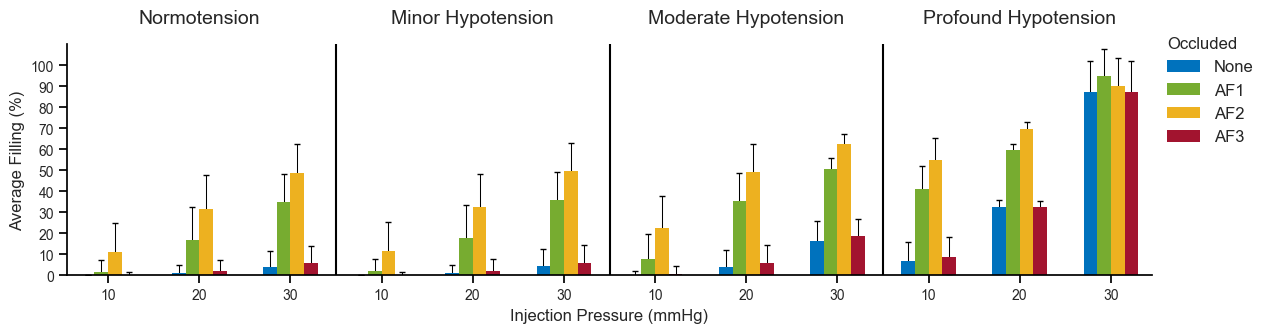

In [861]:
BORDER_COLOR = 'black'

x = np.arange(len(grouped_data) // 4)  # Positions for each group
width = 0.15  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 3))

bar_data = [
    grouped_data[grouped_data['Occluded'] == 'none'],
    grouped_data[grouped_data['Occluded'] == 'AF1'],
    grouped_data[grouped_data['Occluded'] == 'AF2'],
    grouped_data[grouped_data['Occluded'] == 'AF3'],
]

bar_colors = [
    '#0072BD',
    '#77AC30',
    '#EDB120',
    '#A2142F',
]

bar_labels = [
    'None',
    'AF1',
    'AF2',
    'AF3',
]

for i in range(len(bar_data)):
    ax.bar(x - width*1.5 + width*i, bar_data[i]['filling_mean'].values, width, color=bar_colors[i], label=bar_labels[i], edgecolor='none')
    ax.errorbar(x - width*1.5 + width*i, bar_data[i]['filling_mean'].values, yerr=bar_data[i]['filling_std'].values, fmt='none', ecolor='black', capsize=2, elinewidth=0.75, zorder=-1)

plt.setp(
    ax,
    xlim=[-width*3, x[-1] + width*3],
    xticks=x,
    xticklabels=[10, 20, 30] * 4,
    xlabel='Injection Pressure (mmHg)',
    ylabel='Average Filling (%)',
    ylim=[0, 110],
    yticks=range(0, 101, 10),
)

plt.setp(
    ax.spines.values(),
    edgecolor=BORDER_COLOR,
)

plt.setp([ax.xaxis.label, ax.yaxis.label], fontsize=12)

ax.tick_params(
    axis='x',
    labelsize=10,
    bottom=True,
    color=ax.spines['bottom'].get_edgecolor(),
    which='both',
)

ax.tick_params(
    axis='y',
    labelsize=10,
    left=True,
    color=ax.spines['left'].get_edgecolor(),
    which='both',
)

plt.setp([ax.spines['top'], ax.spines['right']], visible=False)

categories = ['Normotension', 'Minor Hypotension', 'Moderate Hypotension', 'Profound Hypotension']
category_positions = [np.mean(x[i*3:(i+1)*3]) for i in range(4)]

for i, label in enumerate(categories):
    ax.text(category_positions[i], ax.get_ylim()[1] + 10, label, ha='center', fontsize=14)

for i in range(1, 4):
    ax.axvline(np.mean(x[i*3-1:i*3+1]), color=BORDER_COLOR, linewidth=1.5)

ax.legend(
    title="Occluded",
    loc='center left',
    bbox_to_anchor=(1, 0.8),
    frameon=False,
    alignment='left',
    fontsize=12,
    title_fontsize=12,
)

plt.grid(False)

In [727]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') &
    (grouped_data['Injection pressure (mmHg)'] == 30) &
    (grouped_data['Occluded'] == 'none') &
    (1 == 1)  # Ignore
]['filling_mean'].values[0]

print(value)

87.32773508925958


## Occlusion by Injection Location

In [754]:
filtered_data = data[
    (~data['Injection location'].isna()) &
    (data['CVP pressure'] == 'normal') &
    (data['Injection pressure (mmHg)'] == 20) &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

164016 rows


In [755]:
filtered_data.loc[:, 'Occluded'] = filtered_data['Occluded'].fillna('none')

grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Occluded', 'Injection location']).agg({
    'Percent filled post-injection (%)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Occluded', 'Injection location', 'filling_mean', 'filling_std']

grouped_data['Occluded'] = pd.Categorical(
    grouped_data['Occluded'],
    categories=['none', 'AF1', 'AF2', 'AF3'],
    ordered=True,
)

grouped_data['Injection location'] = pd.Categorical(
    grouped_data['Injection location'],
    categories=['DV1', 'DV2', 'DV3'],
    ordered=True,
)

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

grouped_data = grouped_data.sort_values(by=['Blood pressure hypotension', 'Injection location', 'Occluded']).reset_index(drop=True)

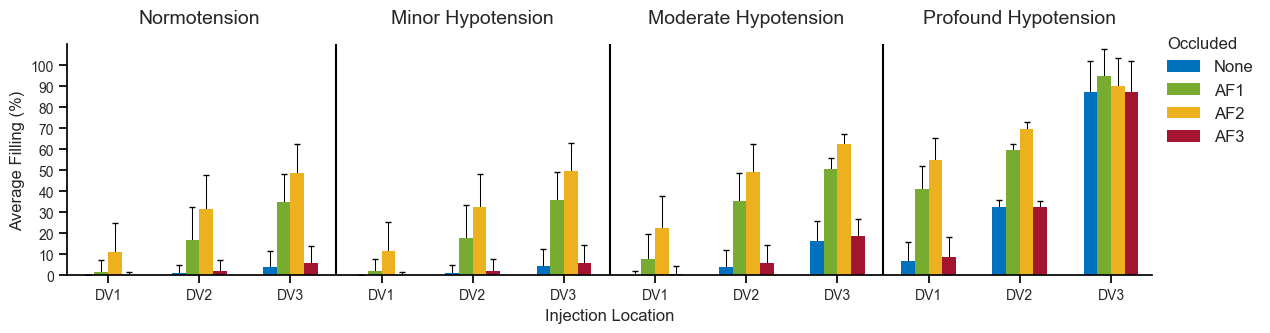

In [862]:
BORDER_COLOR = 'black'

x = np.arange(len(grouped_data) // 4)  # Positions for each group
width = 0.15  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 3))

bar_data = [
    grouped_data[grouped_data['Occluded'] == 'none'],
    grouped_data[grouped_data['Occluded'] == 'AF1'],
    grouped_data[grouped_data['Occluded'] == 'AF2'],
    grouped_data[grouped_data['Occluded'] == 'AF3'],
]

bar_colors = [
    '#0072BD',
    '#77AC30',
    '#EDB120',
    '#A2142F',
]

bar_labels = [
    'None',
    'AF1',
    'AF2',
    'AF3',
]

for i in range(len(bar_data)):
    ax.bar(x - width*1.5 + width*i, bar_data[i]['filling_mean'].values, width, color=bar_colors[i], label=bar_labels[i], edgecolor='none')
    ax.errorbar(x - width*1.5 + width*i, bar_data[i]['filling_mean'].values, yerr=bar_data[i]['filling_std'].values, fmt='none', ecolor='black', capsize=2, elinewidth=0.75, zorder=-1)

plt.setp(
    ax,
    xlim=[-width*3, x[-1] + width*3],
    xticks=x,
    xticklabels=['DV1', 'DV2', 'DV3'] * 4,
    xlabel='Injection Location',
    ylabel='Average Filling (%)',
    ylim=[0, 110],
    yticks=range(0, 101, 10),
)

plt.setp(
    ax.spines.values(),
    edgecolor=BORDER_COLOR,
)

plt.setp([ax.xaxis.label, ax.yaxis.label], fontsize=12)

ax.tick_params(
    axis='x',
    labelsize=10,
    bottom=True,
    color=ax.spines['bottom'].get_edgecolor(),
    which='both',
)

ax.tick_params(
    axis='y',
    labelsize=10,
    left=True,
    color=ax.spines['left'].get_edgecolor(),
    which='both',
)

plt.setp([ax.spines['top'], ax.spines['right']], visible=False)

categories = ['Normotension', 'Minor Hypotension', 'Moderate Hypotension', 'Profound Hypotension']
category_positions = [np.mean(x[i*3:(i+1)*3]) for i in range(4)]

for i, label in enumerate(categories):
    ax.text(category_positions[i], ax.get_ylim()[1] + 10, label, ha='center', fontsize=14)

for i in range(1, 4):
    ax.axvline(np.mean(x[i*3-1:i*3+1]), color=BORDER_COLOR, linewidth=1.5)

ax.legend(
    title="Occluded",
    loc='center left',
    bbox_to_anchor=(1, 0.8),
    frameon=False,
    alignment='left',
    fontsize=12,
    title_fontsize=12,
)

plt.grid(False)

In [ ]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') &
    (grouped_data['Injection pressure (mmHg)'] == 30) &
    (grouped_data['Occluded'] == 'none') &
    (1 == 1)  # Ignore
]['filling_mean'].values[0]

print(value)

## Granular Occlusion

Requires the `granular` dataset.

In [883]:
filtered_data = data[
    (~data['Injection location'].isna()) &
    (data['CVP pressure'] == 'normal') &
    (data['Cardiac phase'] == 'average') &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

94512 rows


In [884]:
filtered_data.loc[:, 'Occluded'] = filtered_data['Occluded'].fillna('None')

grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Occluded', 'Injection pressure (mmHg)']).agg({
    'Percent filled post-injection (%)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Occluded', 'Injection pressure (mmHg)', 'filling_mean', 'filling_std']

grouped_data['Occluded'] = pd.Categorical(
    grouped_data['Occluded'],
    categories=['None', 'AF1', 'AF2', 'AF3'],
    ordered=True,
)

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

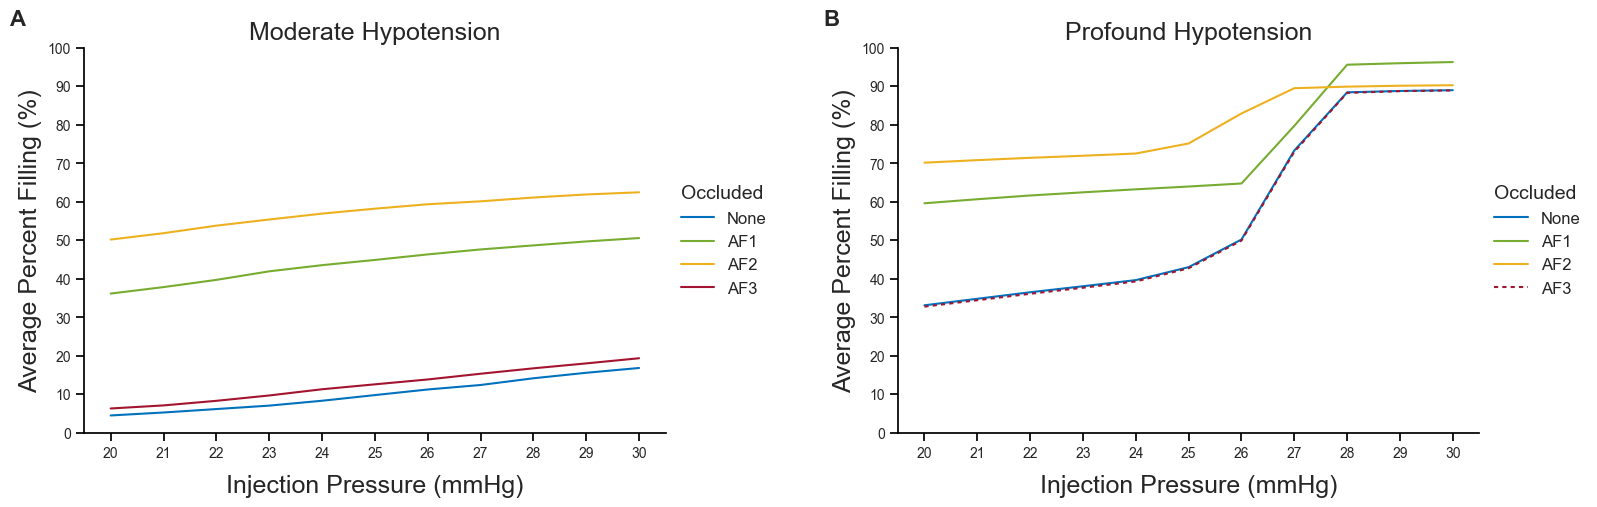

In [893]:
sns.set_theme(style='whitegrid', font_scale=1.5)

fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharey=False)
plt.subplots_adjust(wspace=0.4)

####################
# COMMON FORMATTING
####################

legend_colors = {
    'None': '#0072BD',
    'AF1': '#77AC30',
    'AF2': '#EDB120',
    'AF3': '#A2142F',
}

for i, ax in enumerate(axs):

    ax.grid(False)

    plt.setp(
        ax,
        xlabel='Injection Pressure (mmHg)',
        xticks=range(20, 31),
        ylabel='Average Percent Filling (%)',
        ylim=[0, 100],
        yticks=range(0, 101, 10),
    )

    plt.setp([ax.spines['top'], ax.spines['right']], visible=False)
    plt.setp([ax.spines['left'], ax.spines['bottom']], color='black')

    ax.tick_params(
        axis='x',
        labelsize=10,
        bottom=True,
        color=ax.spines['bottom'].get_edgecolor(),
        which='both',
    )

    ax.tick_params(
        axis='y',
        labelsize=10,
        left=True,
        color=ax.spines['left'].get_edgecolor(),
        which='both',
    )

    ax.set_xlabel(ax.get_xlabel(), labelpad=10)
    ax.text(-0.1, 1.1, 'AB'[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

#######
# AX 0
#######

sns.lineplot(
    ax=axs[0],
    data=grouped_data[grouped_data['Blood pressure hypotension'] == 'moderate'], 
    hue='Occluded',
    palette=legend_colors,
    x='Injection pressure (mmHg)', 
    y='filling_mean', 
)

plt.setp(
    axs[0],
    title='Moderate Hypotension',
)

axs[0].legend(
    alignment='left',
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    frameon=False,
    loc='center left',
    title_fontsize=14,
    title='Occluded',
)

#######
# AX 1
#######

sns.lineplot(
    ax=axs[1],
    dashes={'None': '', 'AF1': '', 'AF2': '', 'AF3': (2, 2)},
    data=grouped_data[grouped_data['Blood pressure hypotension'] == 'profound'], 
    hue='Occluded', 
    palette=legend_colors,
    style='Occluded',
    x='Injection pressure (mmHg)', 
    y='filling_mean', 
)

plt.setp(
    axs[1],
    title='Profound Hypotension',
)

axs[1].legend(
    alignment='left',
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    frameon=False,
    loc='center left',
    title_fontsize=14,
    title='Occluded',
)


In [816]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') &
    (grouped_data['Injection pressure (mmHg)'] == 30) &
    (grouped_data['Occluded'] == 'none') &
    (1 == 1)  # Ignore
]['filling_mean'].values[0]

print(value)

IndexError: index 0 is out of bounds for axis 0 with size 0

## Granular Cardiac Cycle

Requires the `granular` dataset.

In [978]:
filtered_data = data[
    (~data['Injection location'].isna()) &
    (data['CVP pressure'] == 'normal') &
    (data['Occluded'].isna()) &
    (1 == 1)  # Ignore
]

print(f'{len(filtered_data)} rows')

1584 rows


In [979]:
grouped_data = filtered_data.groupby(['Blood pressure hypotension', 'Cardiac phase', 'Injection pressure (mmHg)']).agg({
    'Percent filled post-injection (%)': ['mean', 'std']
}).reset_index()

grouped_data.columns = ['Blood pressure hypotension', 'Cardiac phase', 'Injection pressure (mmHg)', 'filling_mean', 'filling_std']

grouped_data['Cardiac phase'] = grouped_data['Cardiac phase'].replace({
    'diastolic': 'Diastolic',
    'average': 'Intermediate',
    'systolic': 'Systolic',
})

grouped_data['Cardiac phase'] = pd.Categorical(
    grouped_data['Cardiac phase'],
    categories=['Diastolic', 'Intermediate', 'Systolic'],
    ordered=True,
)

grouped_data['Blood pressure hypotension'] = pd.Categorical(
    grouped_data['Blood pressure hypotension'],
    categories=['normal', 'minor', 'moderate', 'profound'],
    ordered=True,
)

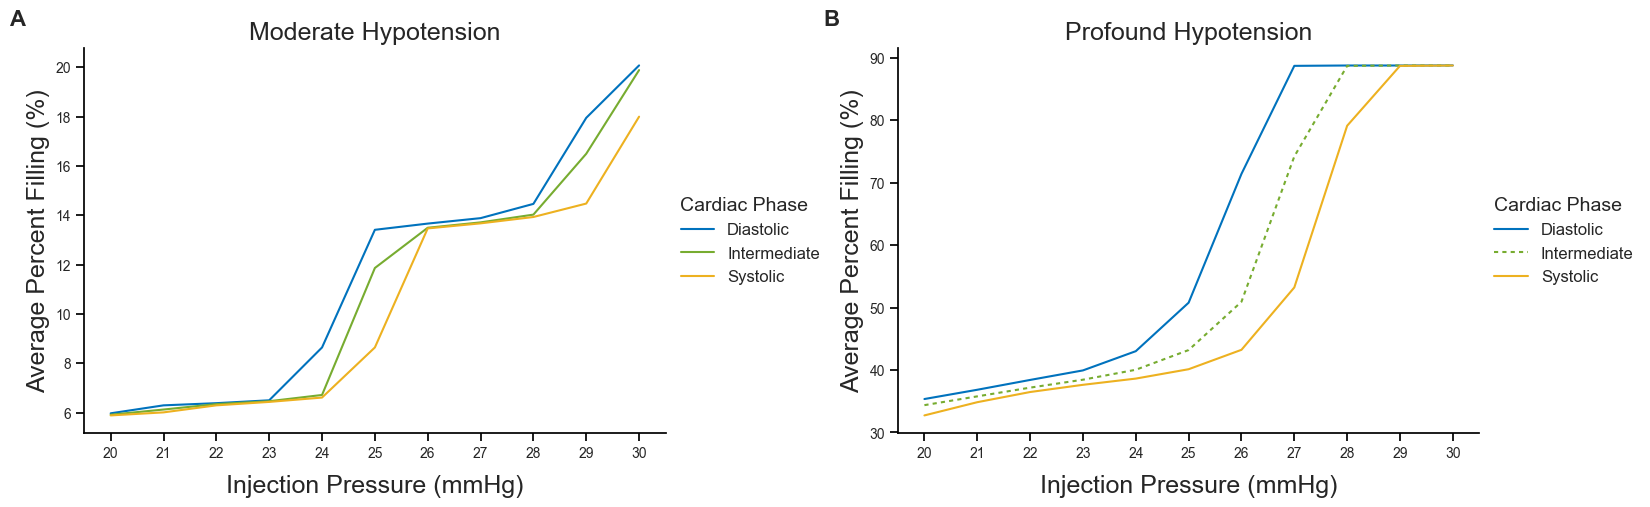

In [980]:
sns.set_theme(style='whitegrid', font_scale=1.5)

fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharey=False)
plt.subplots_adjust(wspace=0.4)

####################
# COMMON FORMATTING
####################

legend_colors = {
    'Diastolic': '#0072BD',
    'Intermediate': '#77AC30',
    'Systolic': '#EDB120',
}

for i, ax in enumerate(axs):

    ax.grid(False)

    plt.setp(
        ax,
        xlabel='Injection Pressure (mmHg)',
        xticks=range(20, 31),
        ylabel='Average Percent Filling (%)',
        # ylim=[0, 100],
        # yticks=range(0, 101, 10),
    )

    plt.setp([ax.spines['top'], ax.spines['right']], visible=False)
    plt.setp([ax.spines['left'], ax.spines['bottom']], color='black')

    ax.tick_params(
        axis='x',
        labelsize=10,
        bottom=True,
        color=ax.spines['bottom'].get_edgecolor(),
        which='both',
    )

    ax.tick_params(
        axis='y',
        labelsize=10,
        left=True,
        color=ax.spines['left'].get_edgecolor(),
        which='both',
    )

    ax.set_xlabel(ax.get_xlabel(), labelpad=10)
    ax.text(-0.1, 1.1, 'AB'[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

#######
# AX 0
#######

sns.lineplot(
    ax=axs[0],
    data=grouped_data[grouped_data['Blood pressure hypotension'] == 'moderate'], 
    hue='Cardiac phase',
    palette=legend_colors,
    x='Injection pressure (mmHg)', 
    y='filling_mean', 
)

plt.setp(
    axs[0],
    title='Moderate Hypotension',
)

axs[0].legend(
    alignment='left',
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    frameon=False,
    loc='center left',
    title_fontsize=14,
    title='Cardiac Phase',
)

#######
# AX 1
#######

sns.lineplot(
    ax=axs[1],
    dashes={'Diastolic': '', 'Intermediate': {2, 2}, 'Systolic': ''},
    data=grouped_data[grouped_data['Blood pressure hypotension'] == 'profound'], 
    hue='Cardiac phase',
    palette=legend_colors,
    style='Cardiac phase',
    x='Injection pressure (mmHg)', 
    y='filling_mean', 
)

plt.setp(
    axs[1],
    title='Profound Hypotension',
)

axs[1].legend(
    alignment='left',
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    frameon=False,
    loc='center left',
    title_fontsize=14,
    title='Cardiac Phase',
)


In [983]:
value = grouped_data[
    (grouped_data['Blood pressure hypotension'] == 'profound') &
    (grouped_data['Injection pressure (mmHg)'] == 30) &
    (grouped_data['Cardiac phase'] == 'Intermediate') &
    (1 == 1)  # Ignore
]['filling_mean'].values[0]

print(value)

88.780175
